# Import Library

In [2]:
# helper function
import os
import cv2
import random
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pytorch and torchvision
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

# warning
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# Define the device to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
# original input path (original dataset)
kaggle_path = "/kaggle/input/2110446-data-science-and-data-engineering-2023/TraffyFondue"
test_path   = "/kaggle/input/test-dataset/"

# input path (cleaned dataset)
input_path = '/kaggle/input/traffy-clean/'

# output path
model_path  = './model/traffy_fondue_classifier.pth'
output_path = '/kaggle/working'

# label mapping
class_to_idx = {
    'canal': 0, 'electric': 1, 'flooding': 2, 'light': 3, 'road': 4, 
    'sanitary': 5, 'sewer': 6, 'sidewalk': 7, 'stray': 8, 'traffic': 9
}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# number of prediction classes
num_classes = 10

# Data Preprocessing

In [21]:
# label of all classes in directory
for label in os.listdir(f'{kaggle_path}/train'):
    directory = f'{kaggle_path}/train/{label}'

    # number of images before cleaning data
    before = len(os.listdir(directory))
    print(f"Before cleaning {label:10}: {before:4} files")

Before cleaning flooding  : 2266 files
Before cleaning road      : 3403 files
Before cleaning sidewalk  : 1000 files
Before cleaning electric  : 1535 files
Before cleaning canal     : 1270 files
Before cleaning traffic   :  600 files
Before cleaning sewer     :  600 files
Before cleaning sanitary  :  700 files
Before cleaning stray     :  500 files
Before cleaning light     : 1400 files



In [3]:
# label of all classes in directory
for label in os.listdir(f'{input_path}/train'):
    directory = f'{input_path}/train/{label}'

    # number of images after cleaning data
    after = len(os.listdir(directory))
    print(f"After cleaning {label:10}: {after:4} files")

After cleaning flooding  :  629 files
After cleaning road      :  738 files
After cleaning sidewalk  :  518 files
After cleaning electric  :  781 files
After cleaning canal     :  535 files
After cleaning traffic   :  401 files
After cleaning sewer     :  544 files
After cleaning sanitary  :  392 files
After cleaning stray     :  306 files
After cleaning light     :  909 files


In [ ]:
def remove_duplicate_image():
    hashes = set()
    for label in os.listdir('./train'):
        directory = f'{input_path}/train/{label}'

        # number of images before cleaning data
        before = len(os.listdir(directory))
        print(f"\nBefore remove duplicate in {label}: {before} files")

        # remove images if duplicated in the same files
        for fileName in os.listdir(directory):
            filePath = os.path.join(directory, fileName)
            digest = hashlib.sha1(open(filePath, 'rb').read()).digest()
            if digest not in hashes:
                hashes.add(digest)
            else:
                os.remove(filePath)

        # number of images after cleaning data
        after = len(os.listdir(directory))
        print(f"After remove duplicate in {label}: {after} files")


def rename_all_files(label):
    dirName = f'{input_path}/train/{label}'
    for idx, fileName in enumerate(os.listdir(dirName)):
        oldName = f"{dirName}/{fileName}"
        newName = f"{dirName}/train_{dirName}_img_{idx}.jpg"
        os.rename(oldName, newName)
    print(f'done renaming {label}')

# Data Visualization

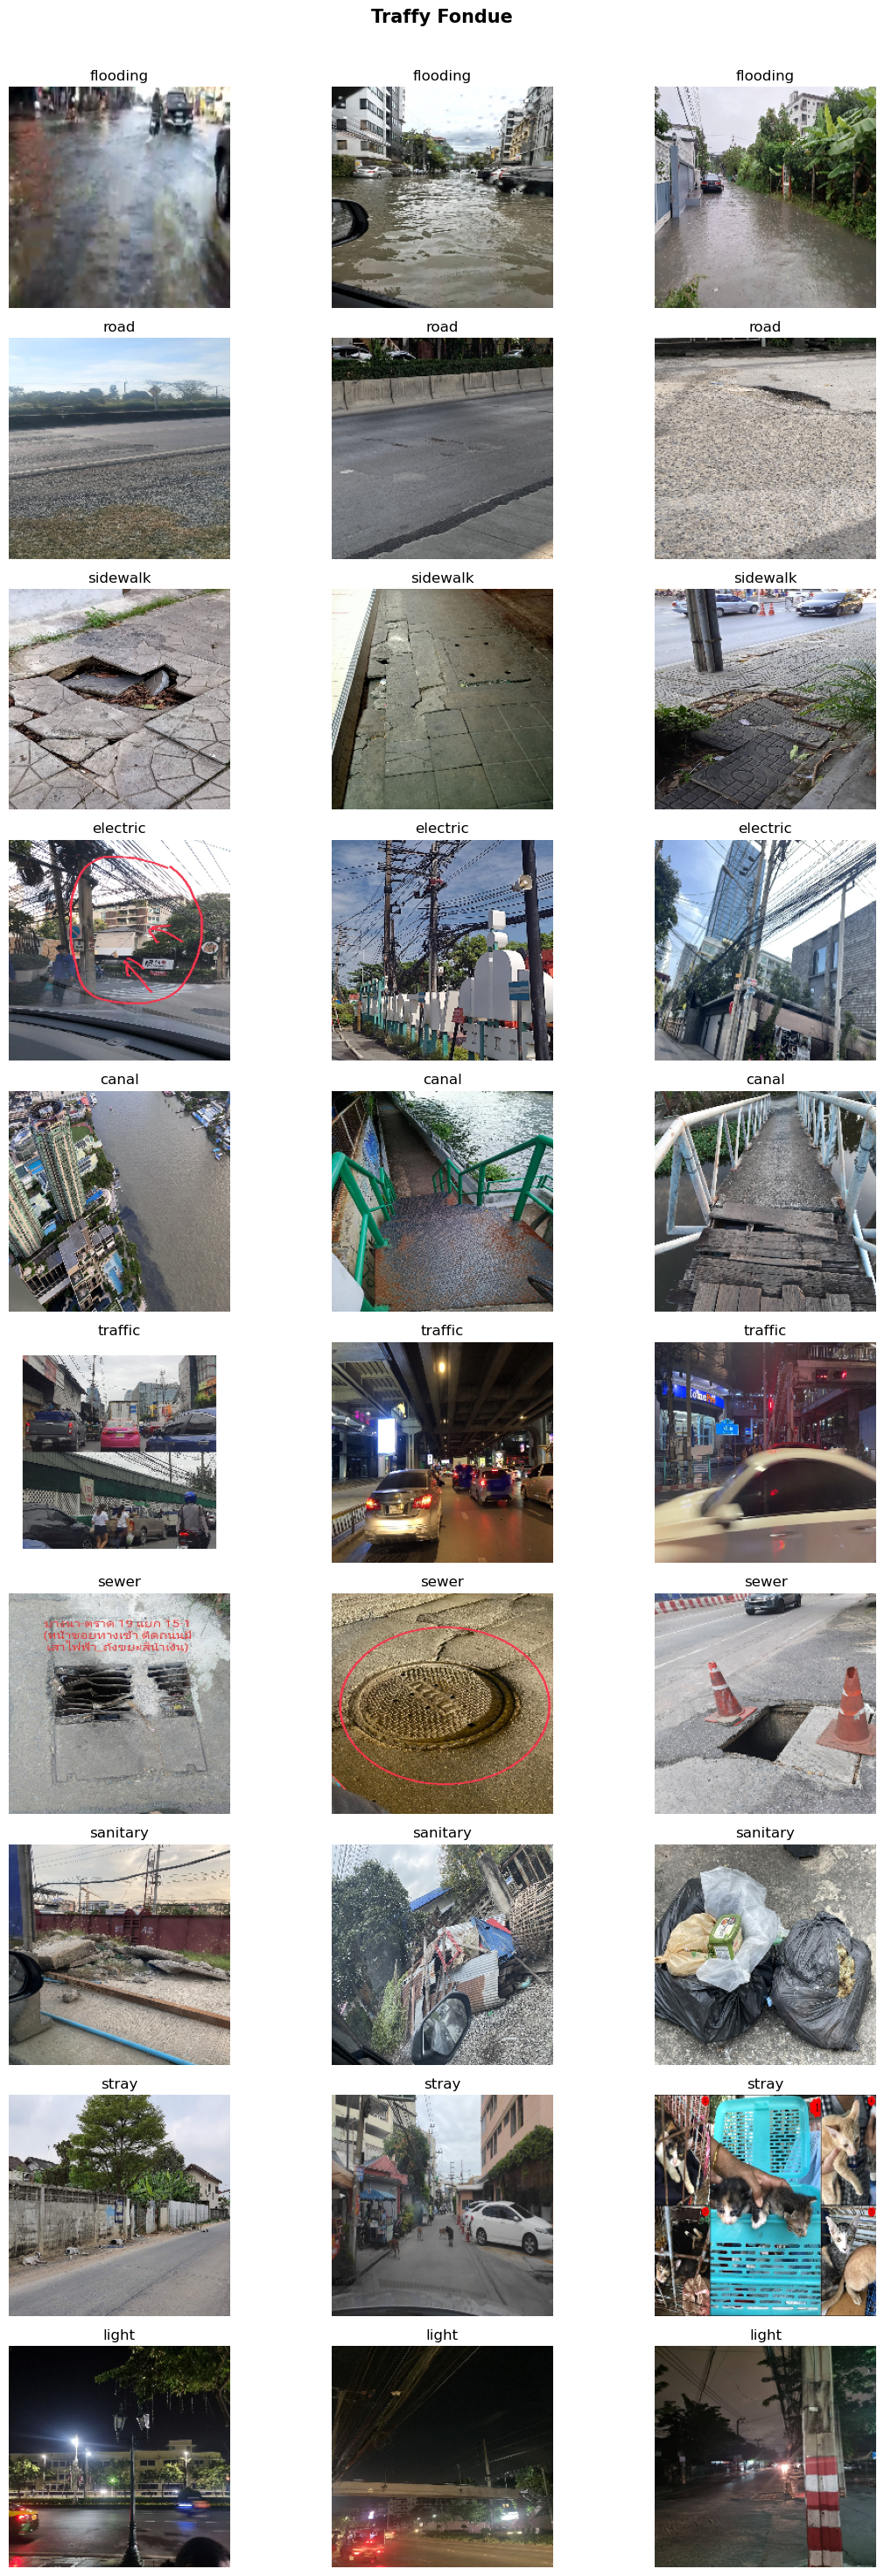

In [19]:
# create 10x3 subplots
fig, axes = plt.subplots(figsize=(12, 30), nrows=10, ncols=3)
fig.suptitle('Traffy Fondue', fontsize=15, fontweight='bold')

for row, label in enumerate(os.listdir(f'{input_path}/train')):
    directory = f'{input_path}/train/{label}'
    directory = os.listdir(directory)
    
    # plot every classes in train dataset
    for col, image_name in enumerate(directory[:3]):
        image_path = f'{input_path}/train/{label}/{image_name}'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224)) 
        
        # create 1x3 subplot for each class
        ax = axes[row, col]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

fig.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Data Loader

In [4]:
# Define the hyperparameters
batch_size = 32
num_epochs = 20
learning_rate = 0.02

# Define the data transformations for augmentation
train_transforms = transforms.Compose([
    transforms.Resize((230, 230)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.507, 0.487, 0.441], 
        std=[0.267, 0.256, 0.276]
    )
])

# Define the data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.507, 0.487, 0.441], 
        std=[0.267, 0.256, 0.276]
    )
])

In [6]:
class TraffyFondueDataset(Dataset):
    max_files_per_dir = 500
    label_image = [
        'canal', 'electric', 'flooding', 'light', 'road', 
        'sanitary', 'sewer', 'sidewalk', 'stray', 'traffic'
    ]
    
    def __init__(self, img_dir, transforms=None):
        super().__init__()
        self.transforms = transforms
        self.dataset = []
        self.targets = []
    
        for label in self.label_image:
            label_num = class_to_idx[label]
            _, _, files = next(os.walk(os.path.join(img_dir, label)))

            count_data = 0
            for image_name in files:
                if count_data > self.max_files_per_dir: break
                input_data = os.path.join(img_dir, label, image_name)
                self.dataset.append(input_data)
                self.targets.append(label_num)
                count_data += 1

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx])
        image = image.convert('RGB')
        x = self.transforms(image)
        y = self.targets[idx]
        return x, y

In [7]:
# Train set 80% and Validate set 20%
dataset = TraffyFondueDataset(f'{input_path}/train', train_transforms)
train_size = int(0.8 * len(dataset))
test_size  = int(0.1 * len(dataset))
valid_size = len(dataset) - train_size - test_size
                 
# train_test_split(data, targets, test_size=0.2, stratify=targets, random_state=42)
train_dataset, test_dataset, valid_dataset = random_split(dataset, [train_size, test_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Sampler so that each class will has the similar amount of data
print(f"dataset size = {len(dataset):,}")
print(f"train size   = {len(train_dataset):,}")
print(f"test size    = {len(test_dataset):,}")
print(f"valid size   = {len(valid_dataset):,}")

dataset size = 4,606
train size   = 3,684
test size    = 460
valid size   = 462


In [7]:
train_dataset.__len__(), test_dataset.__len__(), valid_dataset.__len__()

(3684, 460, 462)

In [8]:
# dict(Counter(custom_dataset.dataset.targets))
def count_image_number_by_class(custom_dataset):
    class_indices = custom_dataset.indices
    class_counter = dict(Counter(custom_dataset.dataset.targets[i] for i in class_indices))
    class_counter = dict(sorted(class_counter.items(), key=lambda x: x[0]))
    for label, number in class_counter.items():
        print(f"({label}) {idx_to_class[label]:>10} directory has {number} images")
        
print("Train Dataset:")
count_image_number_by_class(train_dataset)

print("\nTest Dataset:")
count_image_number_by_class(test_dataset)

print("\nValidate Dataset:")
count_image_number_by_class(valid_dataset)

Train Dataset:
(0)      canal directory has 404 images
(1)   electric directory has 401 images
(2)   flooding directory has 385 images
(3)      light directory has 408 images
(4)       road directory has 407 images
(5)   sanitary directory has 314 images
(6)      sewer directory has 400 images
(7)   sidewalk directory has 399 images
(8)      stray directory has 237 images
(9)    traffic directory has 329 images

Test Dataset:
(0)      canal directory has 46 images
(1)   electric directory has 49 images
(2)   flooding directory has 65 images
(3)      light directory has 49 images
(4)       road directory has 46 images
(5)   sanitary directory has 35 images
(6)      sewer directory has 58 images
(7)   sidewalk directory has 51 images
(8)      stray directory has 27 images
(9)    traffic directory has 34 images

Validate Dataset:
(0)      canal directory has 51 images
(1)   electric directory has 51 images
(2)   flooding directory has 51 images
(3)      light directory has 44 images
(4)  

# Create Model

In [ ]:
# Define the efficientnet model 
model = torchvision.models.efficientnet_b3(pretrained=True)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Linear(in_features=in_features, out_features=num_classes),
    nn.Softmax(dim=1)
)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

# Train model

In [10]:
history_train = {
    'loss': np.zeros(num_epochs), 
    'acc': np.zeros(num_epochs), 
    'f1-score': np.zeros(num_epochs)
}
history_val = {
    'loss': np.zeros(num_epochs), 
    'acc': np.zeros(num_epochs), 
    'f1-score': np.zeros(num_epochs)
}

min_val_loss = 1e10

# loop over the dataset multiple times
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 30)
    model.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0

    with torch.set_grad_enabled(True):
        for batch, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # aggregate statistics
            training_loss += loss.item()
            n += 1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())

    # to change learning rate in every epochs
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits=4, output_dict=True)
    accuracy = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    current = batch * len(inputs)

    print(f"train loss: {training_loss:.2f}  [{current:>5d}/{len(train_dataset):>5d}]", end=' ')
    print(f"accuracy: {accuracy*100:.1f}%, f1-score: {f1*100:.1f}%, support: {support}")
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = accuracy
    history_train['f1-score'][epoch] = f1

    # start validating..
    model.eval()

    optimizer.zero_grad()

    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0

    with torch.no_grad():
        for batch, data in enumerate(valid_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n += 1

    # print statistics
    report = classification_report(y_labels, y_predict, digits=4, output_dict=True)
    accuracy = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    current = batch * len(inputs)

    print(f"valid loss: {validation_loss:.2f}  [{current:>5d}/{len(valid_dataset):>5d}]", end=' ')
    print(f"accuracy: {accuracy*100:.1f}%, f1-score: {f1*100:.1f}%, support: {support}\n")
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = accuracy
    history_val['f1-score'][epoch] = f1

    # save min validation loss
    if validation_loss < min_val_loss:
        torch.save(model.state_dict(), model_path)
        min_val_loss = validation_loss
        print(f"save model with loss = {min_val_loss:.4f}\n")

print("Finished Training!")
print(f"Minimum validation loss is {min_val_loss:4f}")

Epoch 1
------------------------------
train loss: 2.13  [  460/ 3684] accuracy: 45.8%, f1-score: 41.2%, support: 3684
valid loss: 1.86  [  196/  462] accuracy: 67.3%, f1-score: 62.3%, support: 462

save model with loss = 1.8629

Epoch 2
------------------------------
train loss: 1.74  [  460/ 3684] accuracy: 75.8%, f1-score: 73.2%, support: 3684
valid loss: 1.69  [  196/  462] accuracy: 79.0%, f1-score: 75.3%, support: 462

save model with loss = 1.6922

Epoch 3
------------------------------
train loss: 1.65  [  460/ 3684] accuracy: 82.0%, f1-score: 79.4%, support: 3684
valid loss: 1.66  [  196/  462] accuracy: 81.0%, f1-score: 77.3%, support: 462

save model with loss = 1.6646

Epoch 4
------------------------------
train loss: 1.62  [  460/ 3684] accuracy: 85.4%, f1-score: 82.8%, support: 3684
valid loss: 1.65  [  196/  462] accuracy: 82.9%, f1-score: 80.6%, support: 462

save model with loss = 1.6481

Epoch 5
------------------------------
train loss: 1.59  [  460/ 3684] accuracy:

# Inferencing model

In [9]:
# model_path = '/kaggle/input/traffy-model/traffy_fondue_classifier.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Model Evaluate

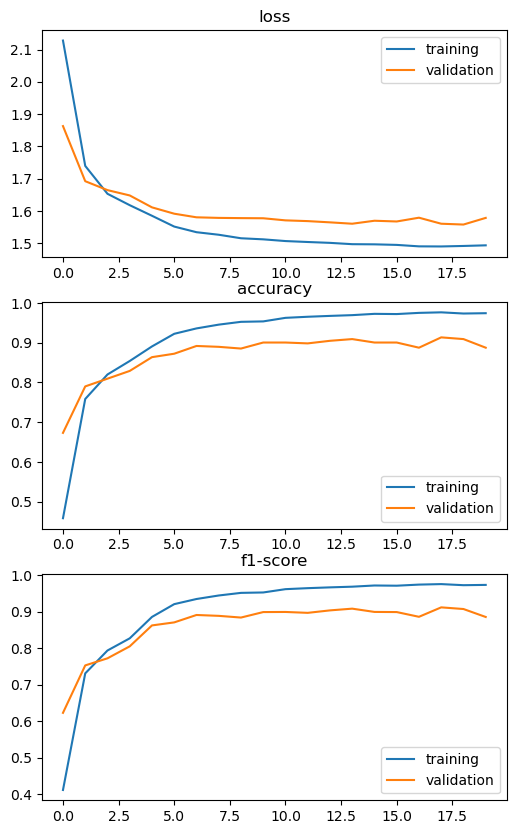

In [12]:
fig, axs = plt.subplots(3, figsize=(6, 10))

# loss
axs[0].plot(history_train['loss'], label='training')
axs[0].plot(history_val['loss'], label='validation')
axs[0].set_title("loss")
axs[0].legend()

# accuracy
axs[1].plot(history_train['acc'], label='training')
axs[1].plot(history_val['acc'], label='validation')
axs[1].set_title("accuracy")
axs[1].legend()

# f1-score
axs[2].plot(history_train['f1-score'], label='training')
axs[2].plot(history_val['f1-score'], label='validation')
axs[2].set_title("f1-score")
axs[2].legend()

plt.show()

testing loss: 1.492

              precision    recall  f1-score   support

           0     0.9643    0.9643    0.9643        56
           1     0.9615    1.0000    0.9804        50
           2     0.9623    0.9808    0.9714        52
           3     0.9796    0.9796    0.9796        49
           4     0.9412    1.0000    0.9697        48
           5     0.9730    0.9000    0.9351        40
           6     0.9767    0.9545    0.9655        44
           7     0.9831    0.9831    0.9831        59
           8     0.9600    0.9231    0.9412        26
           9     1.0000    0.9722    0.9859        36

    accuracy                         0.9696       460
   macro avg     0.9702    0.9658    0.9676       460
weighted avg     0.9699    0.9696    0.9694       460




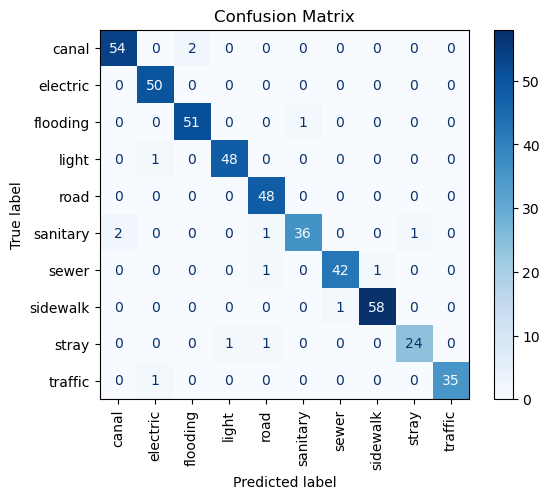

In [12]:
def test(dataloader, model, loss_fn):
    y_predict = []
    y_labels  = []
    test_loss = 0.0
    n = 0

    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            y_labels  += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n += 1

        # print statistics
        test_loss /= n
        report  = classification_report(y_labels, y_predict, digits=4)
        matrix  = confusion_matrix(y_labels, y_predict, labels=list(range(10)))
        display = ConfusionMatrixDisplay(
            confusion_matrix=matrix, display_labels=list(class_to_idx.keys())
        )
        print(f"testing loss: {test_loss:.4}\n\n{report}\n")

    # display cconfusion matrix
    display.plot(cmap=plt.cm.Blues, values_format='g')
    plt.xticks(rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()
    
# display classification report and confusion matrix
test(test_loader, model, criterion)

# Prediction

In [14]:
# test_image = os.listdir(f'{kaggle_path}/test')
test_image = [f"test{i}.jpg" for i in range(4648)]

# create an empty dataframe with the columns
df = pd.DataFrame(columns=["ID", "class"])

# iterate through the test images
for idx in range(len(test_image)):
    image_path = f"{test_path}/test/{test_image[idx]}"

    # predicted_class = predict_traffy_fondue(image_path, model, data_transforms)
    image = Image.open(image_path).convert('RGB')
    
    # transform image to input tensor
    image_tensor = data_transforms(image).float().unsqueeze(0)
    input_tensor = image_tensor.to(device)

    # get model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.max(output, 1)[1].cpu().numpy()[0]

    # append the ID and predicted class to the dataframe
    df = df.append({"ID": idx, "class": predicted_class}, ignore_index=True)

# write the dataframe to a csv file
df.to_csv(f"{output_path}/filenames.csv", index=False)

In [15]:
# display table format
df = pd.read_csv(f'{output_path}/filenames.csv')
df.head(10).T

0  1  2  3  4  5  6  7  8  9
ID     0  1  2  3  4  5  6  7  8  9
class  4  6  1  4  1  7  5  0  1  1

In [16]:
# df.nunique()
df['class'].value_counts()

3    663
1    550
4    505
9    481
0    480
7    476
2    465
5    384
6    377
8    267
Name: class, dtype: int64

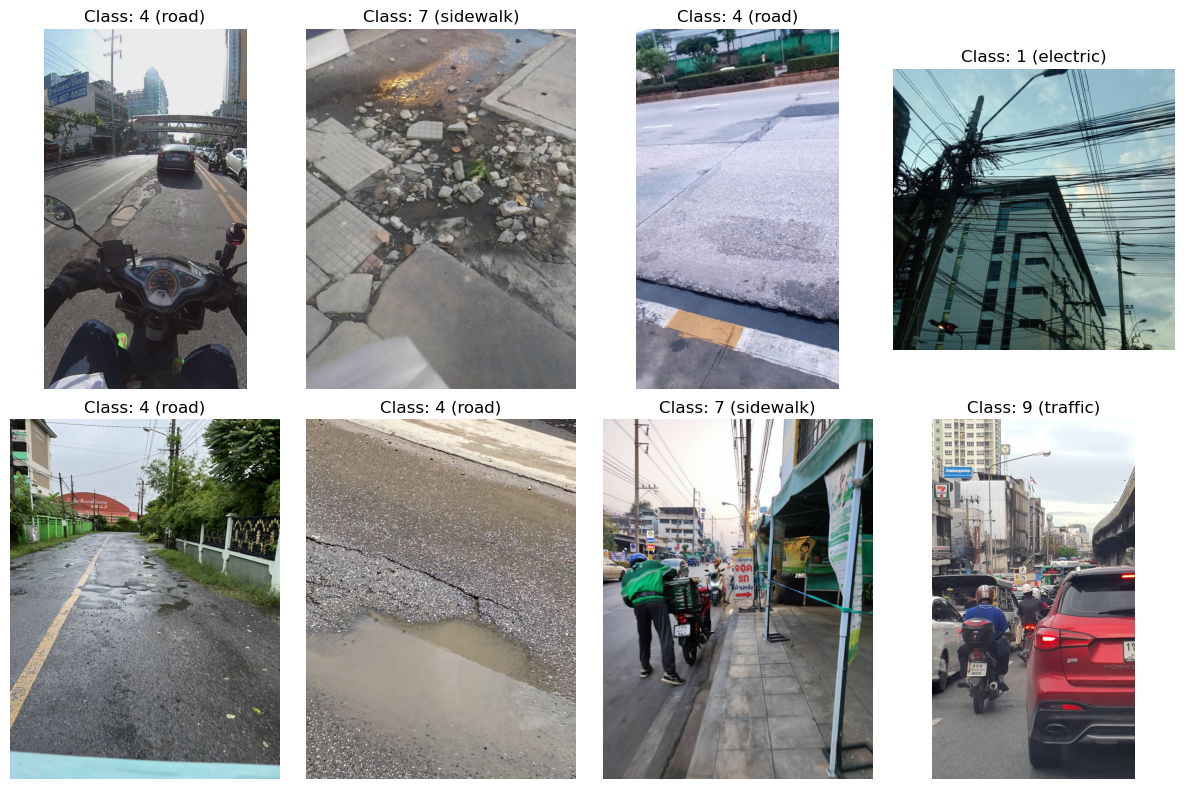

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(10, 8))

for i in range(8):
    idx = random.randint(0, len(test_image))
    image = cv2.imread(f'{test_path}/test/{test_image[idx]}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    label = df['class'][idx]
    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.set_title(f'Class: {label} ({idx_to_class[label]})')
    ax.axis('off')

plt.tight_layout()
plt.show()

# End of the notebook
